# 4. Enriched EDA: Investigating the "Why"

## 4.1. Data Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

db_user = 'root'
db_password = 'Kristine2004$'  
db_host = 'localhost'
db_name = 'banking_analysis'
connection_str = f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}'
engine = create_engine(connection_str)

In [3]:
sql_query = "SELECT * FROM vw_master_analysis;"

df_master = pd.read_sql(sql_query, engine)
    
op_path = '../data/master_banking_analysis.csv'
df_master.to_csv(op_path, index=False)
    
print(f"Master dataset created and saved to '{op_path}'")


Master dataset created and saved to '../data/master_banking_analysis.csv'


In [4]:
df_master.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   State                  35 non-null     object 
 1   Loss_2018_19           35 non-null     float64
 2   Loss_2019_20           35 non-null     float64
 3   YoY_Change_2019_20     35 non-null     float64
 4   Loss_2020_21           35 non-null     float64
 5   YoY_Change_2020_21     34 non-null     float64
 6   Loss_2021_22           35 non-null     float64
 7   YoY_Change_2021_22     35 non-null     float64
 8   Loss_2022_23           35 non-null     float64
 9   YoY_Change_2022_23     33 non-null     float64
 10  Loss_2023_24           35 non-null     float64
 11  YoY_Change_2023_24     31 non-null     float64
 12  Loss_2024_25           35 non-null     float64
 13  YoY_Change_2024_25     34 non-null     float64
 14  Cumulative_Loss        35 non-null     float64
 15  Volatili

In [5]:
# all gsdp in string format
gdp_cols = [c for c in df_master.columns if c.startswith("GSDP")]

for col in gdp_cols:
    df_master[col] = (
        df_master[col]
        .astype(str)
        .str.replace(",", "", regex=False)
        .str.replace("-", "")
        .astype(float)
    )

In [6]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   State                  35 non-null     object 
 1   Loss_2018_19           35 non-null     float64
 2   Loss_2019_20           35 non-null     float64
 3   YoY_Change_2019_20     35 non-null     float64
 4   Loss_2020_21           35 non-null     float64
 5   YoY_Change_2020_21     34 non-null     float64
 6   Loss_2021_22           35 non-null     float64
 7   YoY_Change_2021_22     35 non-null     float64
 8   Loss_2022_23           35 non-null     float64
 9   YoY_Change_2022_23     33 non-null     float64
 10  Loss_2023_24           35 non-null     float64
 11  YoY_Change_2023_24     31 non-null     float64
 12  Loss_2024_25           35 non-null     float64
 13  YoY_Change_2024_25     34 non-null     float64
 14  Cumulative_Loss        35 non-null     float64
 15  Volatili

In [7]:
# Cumulative_Loss 
print("\n Cumulative_Loss stats: ")
display(df_master['Cumulative_Loss'].describe())

# Loss columns
loss_cols = [c for c in df_master.columns if c.startswith("Loss_")]
print("\nLoss columns :", loss_cols)
display(df_master[ ['State'] + loss_cols ].head(8))


 Cumulative_Loss stats: 


count     35.000000
mean      21.048857
std       34.373980
min        0.070000
25%        0.880000
50%        6.150000
75%       24.650000
max      136.770000
Name: Cumulative_Loss, dtype: float64


Loss columns : ['Loss_2018_19', 'Loss_2019_20', 'Loss_2020_21', 'Loss_2021_22', 'Loss_2022_23', 'Loss_2023_24', 'Loss_2024_25']


,State,Loss_2018_19,Loss_2019_20,Loss_2020_21,Loss_2021_22,Loss_2022_23,Loss_2023_24,Loss_2024_25
0,ANDAMAN AND NICOBAR ISLANDS,0.11,0.07,0.00,0.00,0.00,0.00,0.00
1,ANDHRA PRADESH,0.15,1.30,0.72,0.29,3.30,1.76,0.77
2,ARUNACHAL PRADESH,0.01,0.05,0.38,0.00,0.00,0.00,0.01
3,ASSAM,0.81,2.39,1.68,1.04,0.25,0.74,0.06
4,BIHAR,0.34,0.63,1.09,2.08,1.20,0.39,0.42
5,CHANDIGARH,0.20,0.14,0.12,0.43,0.18,0.05,0.21
6,CHHATTISGARH,0.25,0.30,0.21,0.55,3.84,1.50,0.02
7,DADRA AND NAGAR HAVELI AND DAMAN AND DIU,0.00,0.01,0.02,0.02,0.00,0.12,0.01


## 4.2. Forming Hypothesis from variables
 1. States with higher **Loss-to-GSDP percentage** experience higher **volatility** in digital banking losses.
    *   Large economies - process more digital transactions, but they also have stronger fraud monitoring systems.
    *   Smaller economies - larger instability,  when even small fraud events occur.
    *   intensity of loss relative to economic size (Loss/GSDP%) should be linked to volatility.
 2. States with higher **Loss per Capita** show higher **risk** than what raw loss values.
    *   Digital fraud exposure scales with the number of internet/mobile banking users.
    *   Normalizing loss by population helps reveal states where individuals are disproportionately affected, especially small states or UTs with fewer users but concentrated fraud.
 3. States with higher **Branch Density (branches per million people)** will have lower **Loss per Branch**, indicating better fraud mitigation capacity.
    *   Branch density reflects physical financial access and staff availability.
    *   Low-density regions have more concentrated risk, weaker fraud response systems, and higher average loss per branch.
 4. States with lower **literacy rates** experience higher **volatility** in digital banking losses.
    *   Lower literacy (especially digital literacy) increases vulnerability and results in more erratic, unstable loss patterns year-to-year.
 5. States where **loss growth** is more synchronized with **economic growth** show lower loss **volatility**.

## 4.3. Feature Engineering

### 4.3.1 Loss-to-GSDP Percentage
- `Loss_YYYY_pct = Loss_YYYY / GSDP_YYYY`
- `Cumulative_Loss_pct = Cumulative_Loss / GSDP_2022-23`

It measures how big the banking fraud losses are relative to the size of the state’s entire economy.

In [8]:
loss_cols = [
    "Loss_2018_19", "Loss_2019_20", "Loss_2020_21",
    "Loss_2021_22", "Loss_2022_23"
]

gsdp_map = {
    "Loss_2018_19": "GSDP_2018-19",
    "Loss_2019_20": "GSDP_2019-20",
    "Loss_2020_21": "GSDP_2020-21",
    "Loss_2021_22": "GSDP_2021-22",
    "Loss_2022_23": "GSDP_2022-23",
}

for loss_col in loss_cols:
    gsdp_col = gsdp_map[loss_col]
    df_master[f"{loss_col}_pct"] = df_master[loss_col] / df_master[gsdp_col].replace(0, np.nan)


df_master[[
    "State",
    "Loss_2018_19_pct",
    "Loss_2019_20_pct",
    "Loss_2020_21_pct",
    "Loss_2021_22_pct",
    "Loss_2022_23_pct"
]].head(10)

,State,Loss_2018_19_pct,Loss_2019_20_pct,Loss_2020_21_pct,Loss_2021_22_pct,Loss_2022_23_pct
0,ANDAMAN AND NICOBAR ISLANDS,0.001222,0.000714,0.000000,0.000000,0.000000
1,ANDHRA PRADESH,0.000017,0.000140,0.000074,0.000025,0.000253
2,ARUNACHAL PRADESH,0.000040,0.000167,0.001246,0.000000,0.000000
3,ASSAM,0.000262,0.000689,0.000494,0.000253,0.000052
4,BIHAR,0.000064,0.000108,0.000192,0.000321,0.000161
5,CHANDIGARH,0.000499,0.000323,0.000305,0.000933,0.000327
6,CHHATTISGARH,0.000076,0.000087,0.000060,0.000134,0.000827
7,DADRA AND NAGAR HAVELI AND DAMAN AND DIU,0.000000,0.001818,0.003390,0.003125,0.000000
8,GOA,0.000501,0.000413,0.000404,0.000369,0.000112
9,GUJARAT,0.000046,0.000029,0.000079,0.000168,0.000151


### 4.3.2 Loss Per Capita
- `Loss_per_Capita = Cumilative_Loss / Population_Total`

In [9]:
df_master["Loss_per_Capita"] = (
    df_master["Cumulative_Loss"] / df_master["Population_Total"].replace(0, np.nan)
)

df_master[[
    "State",
    "Cumulative_Loss",
    "Population_Total",
    "Loss_per_Capita"
]].head(10)

,State,Cumulative_Loss,Population_Total,Loss_per_Capita
0,ANDAMAN AND NICOBAR ISLANDS,0.18,100608.0,1.789122e-06
1,ANDHRA PRADESH,8.29,18171615.0,4.562060e-07
2,ARUNACHAL PRADESH,0.45,1383727.0,3.252087e-07
3,ASSAM,6.97,1391154.0,5.010229e-06
4,BIHAR,6.15,6714516.0,9.159260e-07
5,CHANDIGARH,1.33,960787.0,1.384282e-06
6,CHHATTISGARH,6.67,3137918.0,2.125613e-06
7,DADRA AND NAGAR HAVELI AND DAMAN AND DIU,0.18,13039.0,1.380474e-05
8,GOA,1.41,1458545.0,9.667168e-07
9,GUJARAT,17.96,17835049.0,1.007006e-06


### 4.3.3 Branches per Million & Loss per Branch
- `Branches_per_Million = Bank_Branches_Total / (Population_Total / 1,000,000)`
- `Loss_per_Branch = Cumulative_Loss / Bank_Branches_Total`

In [10]:
df_master["Branches_per_Million"] = (
    df_master["Bank_Branches_Total"] / (df_master["Population_Total"] / 1_000_000)
)

df_master["Loss_per_Branch"] = (
    df_master["Cumulative_Loss"] / df_master["Bank_Branches_Total"]
)

df_master[[
    "State",
    "Bank_Branches_Total",
    "Branches_per_Million",
    "Cumulative_Loss",
    "Loss_per_Branch"
]].head(30)

,State,Bank_Branches_Total,Branches_per_Million,Cumulative_Loss,Loss_per_Branch
0,ANDAMAN AND NICOBAR ISLANDS,97.0,964.138041,0.18,0.001856
1,ANDHRA PRADESH,7856.0,432.322609,8.29,0.001055
2,ARUNACHAL PRADESH,309.0,223.309945,0.45,0.001456
3,ASSAM,2603.0,1871.108447,6.97,0.002678
4,BIHAR,7895.0,1175.810736,6.15,0.000779
5,CHANDIGARH,572.0,595.345274,1.33,0.002325
6,CHHATTISGARH,2963.0,944.256670,6.67,0.002251
7,DADRA AND NAGAR HAVELI AND DAMAN AND DIU,218.0,16719.073549,0.18,0.000826
8,GOA,823.0,564.260959,1.41,0.001713
9,GUJARAT,9489.0,532.042272,17.96,0.001893


## **4.4. EDA**

### **4.4.1 Loss Per Capita Ranking**


Top 10 States by Loss Per Capita :


,State,Cumulative_Loss,Population_Total,Loss_per_Capita
10,HARYANA,106.46,5952223.0,0.000018
15,KERALA,38.58,2755973.0,0.000014
7,DADRA AND NAGAR HAVELI AND DAMAN AND DIU,0.18,13039.0,0.000014
31,TRIPURA,4.67,399688.0,0.000012
11,HIMACHAL PRADESH,1.92,169758.0,0.000011
20,MEGHALAYA,1.42,143007.0,0.000010
29,TAMIL NADU,89.63,13879395.0,0.000006
3,ASSAM,6.97,1391154.0,0.000005
14,KARNATAKA,78.69,15799896.0,0.000005
18,MAHARASHTRA,136.77,37722136.0,0.000004


C:\Users\KRISTINE\AppData\Local\Temp\ipykernel_31900\2027662964.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


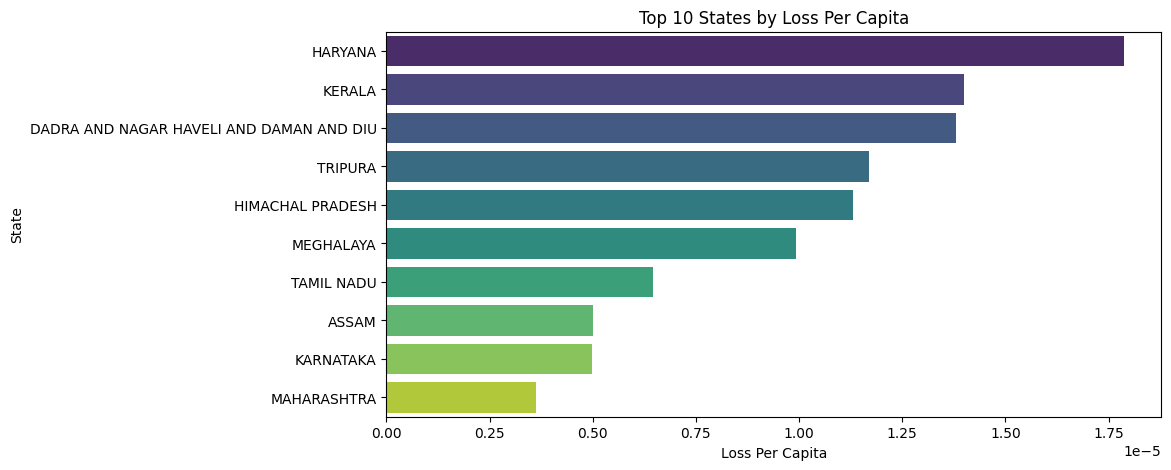

In [ ]:
df_lpc = df_master[['State', 'Cumulative_Loss', 'Population_Total', 'Loss_per_Capita']].copy()

df_lpc_sorted = df_lpc.sort_values('Loss_per_Capita', ascending=False)

print("\nTop 10 States by Loss Per Capita :")
display(df_lpc_sorted.head(10))

plt.figure(figsize=(10,5))
sns.barplot(
    data=df_lpc_sorted.head(10),
    x='Loss_per_Capita', 
    y='State',
    palette='viridis'
)
plt.title('Top 10 States by Loss Per Capita')
plt.xlabel('Loss Per Capita')
plt.ylabel('State')
plt.show()


**Population rank on Top Loss per Capita States**

In [59]:
top10_lpc = (
    df_master[['State', 'Loss_per_Capita', 'Population_Total']]
    .sort_values('Loss_per_Capita', ascending=False)
    .head(10)
    .copy()
)

df_master['Population_Total'] = df_master['Population_Total'].fillna(0)

df_master['Population_Rank'] = (
    df_master['Population_Total']
    .rank(ascending=False)
    .astype(int)
)

top10_lpc = top10_lpc.merge(
    df_master[['State', 'Population_Rank']],
    on='State',
    how='left'
)

top10_lpc


,State,Loss_per_Capita,Population_Total,Population_Rank
0,HARYANA,0.000018,5952223.0,13
1,KERALA,0.000014,2755973.0,18
2,DADRA AND NAGAR HAVELI AND DAMAN AND DIU,0.000014,13039.0,34
3,TRIPURA,0.000012,399688.0,27
4,HIMACHAL PRADESH,0.000011,169758.0,30
5,MEGHALAYA,0.000010,143007.0,31
6,TAMIL NADU,0.000006,13879395.0,8
7,ASSAM,0.000005,1391154.0,21
8,KARNATAKA,0.000005,15799896.0,7
9,MAHARASHTRA,0.000004,37722136.0,1


#### **Insight 1**
High loss-per-capita is not a popuation based phenomenon. Small, medium and large population states appear in the top ranks, showing that some regions carry high individual risk regardless of population size.

-----------------------------------------------------------------------------------------------------------

### **4.4.2 Loss-to-GDP% Ranking**

Top 10 States by Loss-to-GSDP% (using Loss_2022_23_pct) with Population Rank:


,State,Loss_2022_23_pct,Population_Total,Population_Rank
0,HARYANA,0.001322,5952223.0,13
1,CHHATTISGARH,0.000827,3137918.0,16
2,DELHI,0.000684,13481997.0,9
3,RAJASTHAN,0.000488,10443016.0,11
4,TELANGANA,0.000459,35003674.0,2
5,UTTAR PRADESH,0.000423,25302925.0,3
6,MAHARASHTRA,0.000364,37722136.0,1
7,CHANDIGARH,0.000327,960787.0,24
8,KERALA,0.000256,2755973.0,18
9,ANDHRA PRADESH,0.000253,18171615.0,4


C:\Users\KRISTINE\AppData\Local\Temp\ipykernel_31900\3929490762.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


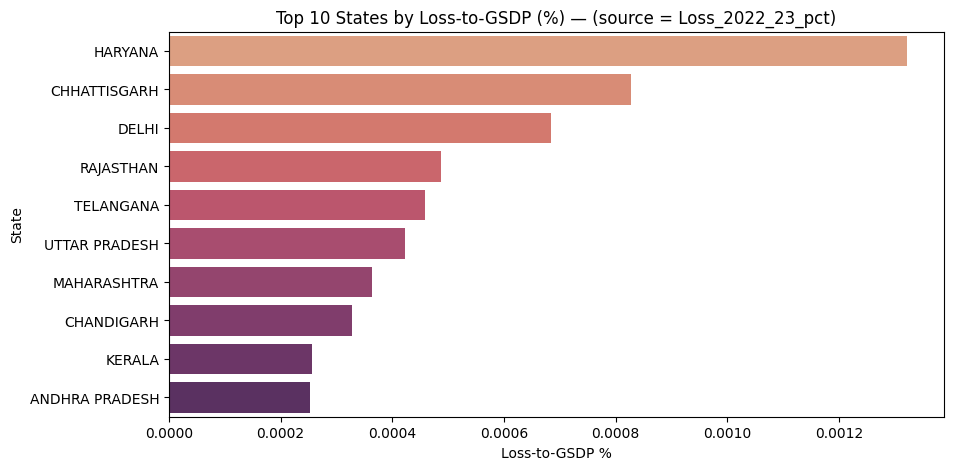

In [ ]:

top10_gsdp = (
    df_master[['State', 'Loss_2022_23_pct', 'Population_Total'] ]
    .sort_values('Loss_2022_23_pct', ascending=False)
    .head(10)
    .copy()
)


df_master['Population_Total'] = df_master['Population_Total'].fillna(0)
df_master['Population_Rank'] = df_master['Population_Total'].rank(ascending=False, method='min').astype('Int64')

top10_gsdp = top10_gsdp.merge(df_master[['State','Population_Rank']], on='State', how='left')

print("Top 10 States by Loss-to-GSDP% (using Loss_2022_23_pct) with Population Rank:")
display(top10_gsdp)

plt.figure(figsize=(10,5))
sns.barplot(
    data=top10_gsdp.sort_values('Loss_2022_23_pct', ascending=False),
    x='Loss_2022_23_pct',
    y='State',
    palette='flare'
)
plt.title('Top 10 States by Loss-to-GSDP (%) — (source = Loss_2022_23_pct)')
plt.xlabel('Loss-to-GSDP %')
plt.ylabel('State')
plt.show()


#### **Insight 2**
- Loss-to-GSDP% is highest in medium-to-large population states, showing that bigger economies like Haryana, Delhi, Rajasthan, Telangana and Maharashtra experience a stronger economic impact from fraud than smaller states.
- Large states are losing a bigger share of their economy to digital fraud, which means fraud is scaling faster than ecomomic growth.

-------------------------------------------------------------

### **4.4.3 Loss per Branch Ranking**


Top 10 States by Loss per Branch:


,State,Cumulative_Loss,Bank_Branches_Total,Loss_per_Branch
10,HARYANA,106.46,5062.0,0.021031
31,TRIPURA,4.67,559.0,0.008354
18,MAHARASHTRA,136.77,16789.0,0.008146
29,TAMIL NADU,89.63,12975.0,0.006908
14,KARNATAKA,78.69,12013.0,0.006550
15,KERALA,38.58,6940.0,0.005559
30,TELANGANA,27.77,6088.0,0.004561
34,WEST BENGAL,33.45,8328.0,0.004017
32,UTTAR PRADESH,74.12,19997.0,0.003707
20,MEGHALAYA,1.42,501.0,0.002834


C:\Users\KRISTINE\AppData\Local\Temp\ipykernel_31900\2997716718.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


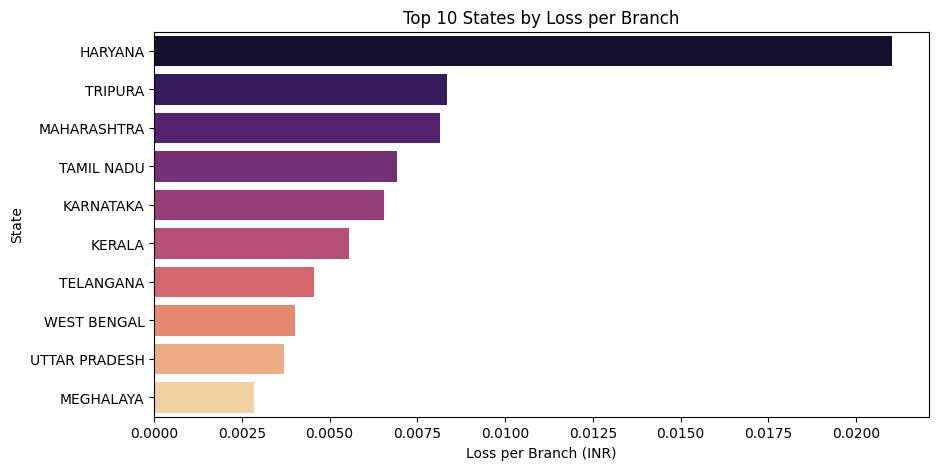

In [67]:
df_lpb = df_master[['State', 'Cumulative_Loss', 'Bank_Branches_Total', 'Loss_per_Branch']].copy()

df_lpb_sorted = df_lpb.sort_values('Loss_per_Branch', ascending=False)

print("\nTop 10 States by Loss per Branch:")
display(df_lpb_sorted.head(10))

plt.figure(figsize=(10,5))
sns.barplot(
    data=df_lpb_sorted.head(10),
    x='Loss_per_Branch',
    y='State',
    palette='magma'
)
plt.title('Top 10 States by Loss per Branch')
plt.xlabel('Loss per Branch (INR)')
plt.ylabel('State')
plt.show()


In [69]:
top10_lpb = (
    df_master[['State', 'Loss_per_Branch', 'Branches_per_Million']]
    .sort_values('Loss_per_Branch', ascending=False)
    .head(10)
    .copy()
)

df_master['Branch_Density_Rank'] = (
    df_master['Branches_per_Million']
    .rank(ascending=True, method='min')     # ascending → smallest → rank 1
    .astype('Int64')
)

top10_lpb = top10_lpb.merge(
    df_master[['State', 'Branch_Density_Rank']],
    on='State',
    how='left'
)

display(top10_lpb)


,State,Loss_per_Branch,Branches_per_Million,Branch_Density_Rank
0,HARYANA,0.021031,850.438567,16
1,TRIPURA,0.008354,1398.590901,25
2,MAHARASHTRA,0.008146,445.070237,5
3,TAMIL NADU,0.006908,934.839019,17
4,KARNATAKA,0.006550,760.321460,12
5,KERALA,0.005559,2518.166905,29
6,TELANGANA,0.004561,173.924600,1
7,WEST BENGAL,0.004017,461.039990,6
8,UTTAR PRADESH,0.003707,790.303888,14
9,MEGHALAYA,0.002834,3503.325012,31


### **Insight 3**
Even though we expect states with fewer branches per million people to show higher loss-per-branch (due to heavier workload per branch), the data shows no such pattern. Both high-density and low-density states appear in the top ranks for loss-per-branch.

--------------------------------------------------------------

Top 10 States by Branch Density:


,State,Branches_per_Million
7,DADRA AND NAGAR HAVELI AND DAMAN AND DIU,16719.073549
11,HIMACHAL PRADESH,14161.335548
20,MEGHALAYA,3503.325012
22,NAGALAND,2536.820249
15,KERALA,2518.166905
33,UTTARAKHAND,2003.883924
3,ASSAM,1871.108447
24,ODISHA,1855.666258
31,TRIPURA,1398.590901
26,PUNJAB,1364.336856


C:\Users\KRISTINE\AppData\Local\Temp\ipykernel_31900\834258030.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


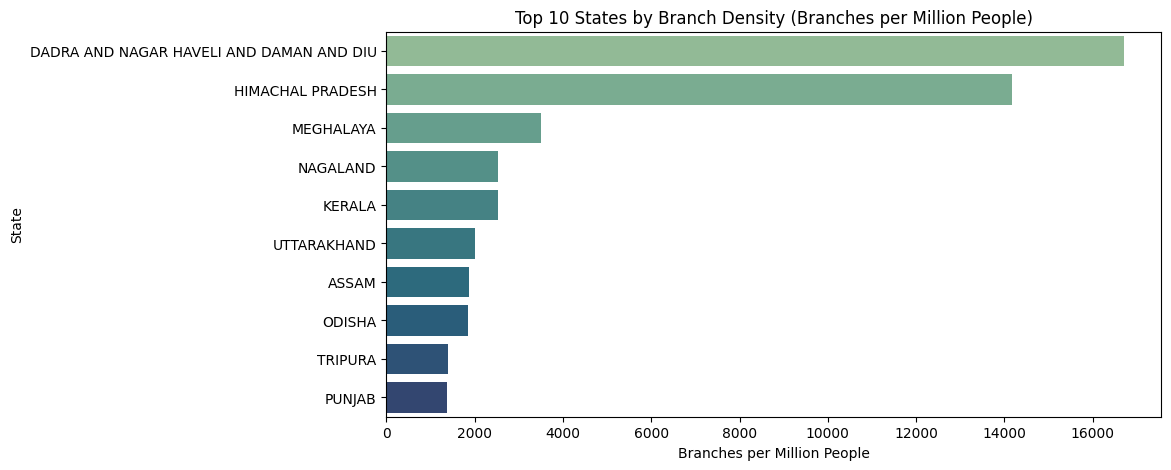

In [70]:
df_bpm = df_master[['State', 'Branches_per_Million']].copy()

df_bpm_sorted = df_bpm.sort_values('Branches_per_Million', ascending=False)

print("Top 10 States by Branch Density:")
display(df_bpm_sorted.head(10))

plt.figure(figsize=(10,5))
sns.barplot(
    data=df_bpm_sorted.head(10),
    x='Branches_per_Million',
    y='State',
    palette='crest'
)
plt.title('Top 10 States by Branch Density (Branches per Million People)')
plt.xlabel('Branches per Million People')
plt.ylabel('State')
plt.show()


_________________________________________________

### **4.4.1 (A) Branch Density vs Loss per Capita**

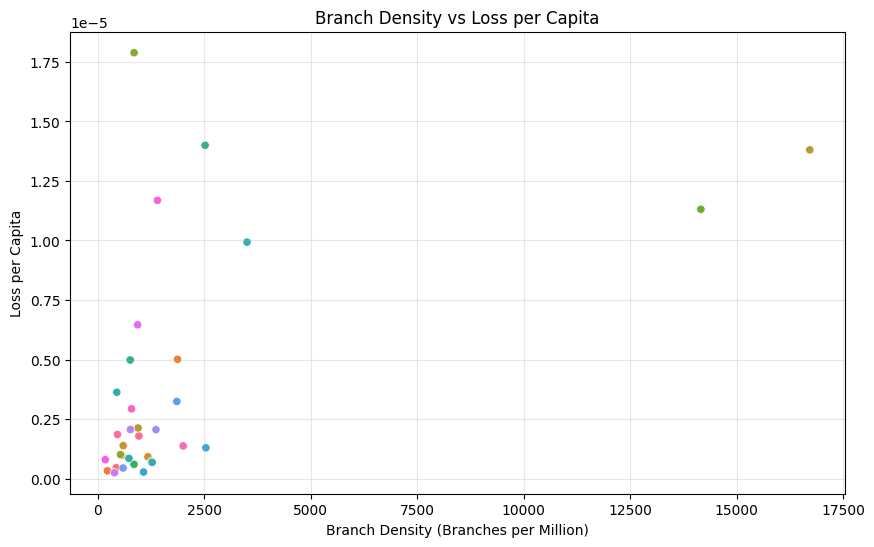

,Branches_per_Million,Loss_per_Capita
Branches_per_Million,1.000000,0.524398
Loss_per_Capita,0.524398,1.000000


In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_master,
    x='Branches_per_Million',
    y='Loss_per_Capita',
    hue='State',
    legend=False
)

plt.xlabel("Branch Density (Branches per Million)")
plt.ylabel("Loss per Capita")
plt.title("Branch Density vs Loss per Capita")
plt.grid(alpha=0.3)
plt.show()

# Correlation
df_master[['Branches_per_Million','Loss_per_Capita']].corr(method='spearman')


In [74]:
top_branch_density = (
    df_master[['State', 'Branches_per_Million', 'Loss_per_Capita', 'Population_Total']]
    .sort_values('Branches_per_Million', ascending=False)
    .head(10)
)

print("Top 10 States by Branch Density (Branches per Million):")
display(top_branch_density)


Top 10 States by Branch Density (Branches per Million):


,State,Branches_per_Million,Loss_per_Capita,Population_Total
7,DADRA AND NAGAR HAVELI AND DAMAN AND DIU,16719.073549,0.000014,13039.0
11,HIMACHAL PRADESH,14161.335548,0.000011,169758.0
20,MEGHALAYA,3503.325012,0.000010,143007.0
22,NAGALAND,2536.820249,0.000001,123777.0
15,KERALA,2518.166905,0.000014,2755973.0
33,UTTARAKHAND,2003.883924,0.000001,1340397.0
3,ASSAM,1871.108447,0.000005,1391154.0
24,ODISHA,1855.666258,0.000003,3003234.0
31,TRIPURA,1398.590901,0.000012,399688.0
26,PUNJAB,1364.336856,0.000002,5821876.0


In [75]:
# Export enriched master dataset
output_path = "../data/master_banking_analysis_enriched.csv"
df_master.to_csv(output_path, index=False)

print("Enriched dataset saved to:", output_path)


Enriched dataset saved to: ../data/master_banking_analysis_enriched.csv


------------------------------------------------------------------

______________________________________________________________________________________________

_______________________________________________________________________________________________________________________________________________________

### 4.4.1 H1
*   States with higher Loss-to-GSDP percentage -> higher volatility in digital banking losses.


In [11]:
df_master[[
    "State",
    "Volatility",
    "Loss_2018_19_pct",
    "Loss_2019_20_pct",
    "Loss_2020_21_pct",
    "Loss_2021_22_pct",
    "Loss_2022_23_pct"
]].head()

,State,Volatility,Loss_2018_19_pct,Loss_2019_20_pct,Loss_2020_21_pct,Loss_2021_22_pct,Loss_2022_23_pct
0,ANDAMAN AND NICOBAR ISLANDS,40.554015,0.001222,0.000714,0.000000,0.000000,0.000000
1,ANDHRA PRADESH,500.145323,0.000017,0.000140,0.000074,0.000025,0.000253
2,ARUNACHAL PRADESH,NaN,0.000040,0.000167,0.001246,0.000000,0.000000
3,ASSAM,133.407604,0.000262,0.000689,0.000494,0.000253,0.000052
4,BIHAR,68.787467,0.000064,0.000108,0.000192,0.000321,0.000161


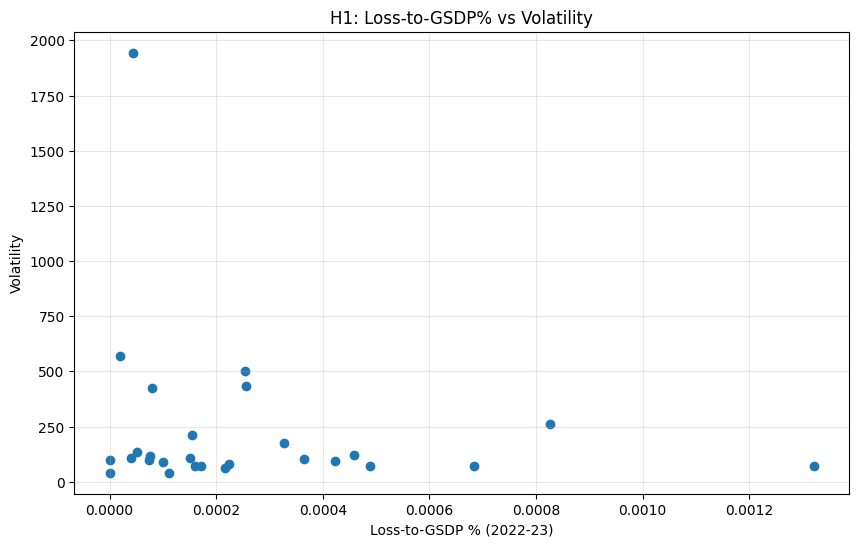

In [12]:
plt.figure(figsize=(10,6))
plt.scatter(
    df_master["Loss_2022_23_pct"],
    df_master["Volatility"],
)

plt.xlabel("Loss-to-GSDP % (2022-23)")
plt.ylabel("Volatility")
plt.title("H1: Loss-to-GSDP% vs Volatility")
plt.grid(True, alpha=0.3)

plt.show()

##### --- **Relationship** --- 

In [13]:
corr_h1 = df_master[["Loss_2022_23_pct", "Volatility"]].corr()
corr_h1


,Loss_2022_23_pct,Volatility
Loss_2022_23_pct,1.000000,-0.182058
Volatility,-0.182058,1.000000


Pearson failed because:
*   extreme outliers distort linearity.
*   relationship is not linear.

In [14]:
# use spearmnan's correlation - less sensitive to outliers
from scipy.stats import spearmanr

corr, p = spearmanr(df_master["Loss_2022_23_pct"].fillna(0), df_master["Volatility"].fillna(0))
print("Spearman's Rank Correlation Coefficient:", corr, "p-value:", p)

Spearman's Rank Correlation Coefficient: 0.4326814058956916 p-value: 0.009430663129017814


*   This is a moderate positive correlation. (0.40 - 0.69)
*   relationship is nonlinear but monotonic.
*   higher Loss-to-GSDP% tend to have higher volatility

##### --- **Top volatility looking at outliers** ---

In [15]:
cols = ["State","Volatility","Loss_2022_23_pct","GSDP_2022-23","Cumulative_Loss","Loss_per_Capita","Population_Total","Bank_Branches_Total"]
top_vol = df_master.sort_values("Volatility", ascending=False).head(10)
top_vol[cols]


,State,Volatility,Loss_2022_23_pct,GSDP_2022-23,Cumulative_Loss,Loss_per_Capita,Population_Total,Bank_Branches_Total
20,MEGHALAYA,1944.007257,0.000043,466.0,1.42,9.929584e-06,143007.0,501.0
13,JHARKHAND,570.427849,0.000019,4174.0,2.56,5.983742e-07,4278259.0,3632.0
1,ANDHRA PRADESH,500.145323,0.000253,13035.0,8.29,4.562060e-07,18171615.0,7856.0
15,KERALA,432.839177,0.000256,10236.0,38.58,1.399869e-05,2755973.0,6940.0
24,ODISHA,422.865583,0.000080,7596.0,9.73,3.239841e-06,3003234.0,5573.0
6,CHHATTISGARH,261.025497,0.000827,4644.0,6.67,2.125613e-06,3137918.0,2963.0
14,KARNATAKA,210.245098,0.000155,22700.0,78.69,4.980413e-06,15799896.0,12013.0
5,CHANDIGARH,174.170071,0.000327,550.0,1.33,1.384282e-06,960787.0,572.0
3,ASSAM,133.407604,0.000052,4788.0,6.97,5.010229e-06,1391154.0,2603.0
30,TELANGANA,122.540793,0.000459,13118.0,27.77,7.933453e-07,35003674.0,6088.0


In [16]:
cols = ["State","Loss_2022_23_pct","Volatility","GSDP_2022-23","Cumulative_Loss","Loss_per_Capita","Population_Total","Bank_Branches_Total"]
top_vol = df_master.sort_values("Loss_2022_23_pct", ascending=False).head(10)
top_vol[cols]

,State,Loss_2022_23_pct,Volatility,GSDP_2022-23,Cumulative_Loss,Loss_per_Capita,Population_Total,Bank_Branches_Total
10,HARYANA,0.001322,70.903355,9841.0,106.46,1.788575e-05,5952223.0,5062.0
6,CHHATTISGARH,0.000827,261.025497,4644.0,6.67,2.125613e-06,3137918.0,2963.0
23,DELHI,0.000684,70.673030,10147.0,34.47,2.556743e-06,13481997.0,NaN
27,RAJASTHAN,0.000488,71.436010,13579.0,21.53,2.061665e-06,10443016.0,8003.0
30,TELANGANA,0.000459,122.540793,13118.0,27.77,7.933453e-07,35003674.0,6088.0
32,UTTAR PRADESH,0.000423,92.893810,22580.0,74.12,2.929306e-06,25302925.0,19997.0
18,MAHARASHTRA,0.000364,104.029052,36459.0,136.77,3.625723e-06,37722136.0,16789.0
5,CHANDIGARH,0.000327,174.170071,550.0,1.33,1.384282e-06,960787.0,572.0
15,KERALA,0.000256,432.839177,10236.0,38.58,1.399869e-05,2755973.0,6940.0
1,ANDHRA PRADESH,0.000253,500.145323,13035.0,8.29,4.562060e-07,18171615.0,7856.0


In [17]:
cols = ["State","Loss_2022_23_pct","Volatility","GSDP_2022-23","Cumulative_Loss","Loss_per_Capita","Population_Total","Bank_Branches_Total"]
top_vol = df_master.sort_values("Population_Total", ascending=False).head(10)
top_vol[cols]

,State,Loss_2022_23_pct,Volatility,GSDP_2022-23,Cumulative_Loss,Loss_per_Capita,Population_Total,Bank_Branches_Total
18,MAHARASHTRA,0.000364,104.029052,36459.0,136.77,3.625723e-06,37722136.0,16789.0
30,TELANGANA,0.000459,122.540793,13118.0,27.77,7.933453e-07,35003674.0,6088.0
32,UTTAR PRADESH,0.000423,92.893810,22580.0,74.12,2.929306e-06,25302925.0,19997.0
1,ANDHRA PRADESH,0.000253,500.145323,13035.0,8.29,4.562060e-07,18171615.0,7856.0
34,WEST BENGAL,0.000172,72.615009,15318.0,33.45,1.851800e-06,18063509.0,8328.0
9,GUJARAT,0.000151,108.362498,22034.0,17.96,1.007006e-06,17835049.0,9489.0
14,KARNATAKA,0.000155,210.245098,22700.0,78.69,4.980413e-06,15799896.0,12013.0
29,TAMIL NADU,0.000216,63.322991,23934.0,89.63,6.457774e-06,13879395.0,12975.0
23,DELHI,0.000684,70.673030,10147.0,34.47,2.556743e-06,13481997.0,NaN
17,MADHYA PRADESH,0.000076,117.432047,12465.0,9.35,8.482194e-07,11023091.0,8047.0


In [18]:
vol_mean = df_master['Volatility'].mean()
print("Mean Volatility : ", vol_mean)
pop_mean = df_master['Population_Total'].mean()
print("Mean Population : ", pop_mean)
 

Mean Volatility :  228.53049596449213
Mean Population :  7629087.117647059


In [19]:
small_states = df_master[df_master['Population_Total'] < pop_mean]
large_states = df_master[df_master['Population_Total'] >= pop_mean]

print("\nVolatility (SMALL states):")
display(small_states[['State', 'Population_Total', 'Volatility']].sort_values('Volatility', ascending=False).head(10))

print("\nVolatility (LARGE states):")
display(large_states[['State', 'Population_Total', 'Volatility']].sort_values('Volatility', ascending=False).head(10))

print("\nAverage Volatility:")
print(" Small states:", small_states['Volatility'].mean())
print(" Large states:", large_states['Volatility'].mean())


Volatility (SMALL states):


,State,Population_Total,Volatility
20,MEGHALAYA,143007.0,1944.007257
13,JHARKHAND,4278259.0,570.427849
15,KERALA,2755973.0,432.839177
24,ODISHA,3003234.0,422.865583
6,CHHATTISGARH,3137918.0,261.025497
5,CHANDIGARH,960787.0,174.170071
3,ASSAM,1391154.0,133.407604
33,UTTARAKHAND,1340397.0,106.539599
11,HIMACHAL PRADESH,169758.0,99.598140
22,NAGALAND,123777.0,98.130676



Volatility (LARGE states):


,State,Population_Total,Volatility
1,ANDHRA PRADESH,18171615.0,500.145323
14,KARNATAKA,15799896.0,210.245098
30,TELANGANA,35003674.0,122.540793
17,MADHYA PRADESH,11023091.0,117.432047
9,GUJARAT,17835049.0,108.362498
18,MAHARASHTRA,37722136.0,104.029052
32,UTTAR PRADESH,25302925.0,92.893810
34,WEST BENGAL,18063509.0,72.615009
27,RAJASTHAN,10443016.0,71.436010
23,DELHI,13481997.0,70.673030



Average Volatility:
 Small states: 289.78923312268785
 Large states: 139.4268782798439


------------------------------------------------------------------------------------------------------------

### **Insight 1: Population Influence on Volatility**

Using the mean population threshold (~76 lakh), states were grouped into "small" and "large".

pattern:
- Small-population states show **much higher volatility** (average ~ 289).
- Large-population states show **more stable volatility** (average ~ 139).
- Extreme volatility values (400+, 500+, 1900+) appear **only in small states**.

Interpretation:
- Small states have fewer users, fewer branches, and lower transaction volumes, so even small changes in annual losses create drastic change. 
- This produces non-linear, scattered behavior in the Loss/GSDP%–Volatility relationship.

### **Conclusion for H1**

- Spearman correlation (rho = 0.43, p < 0.01) shows a statistically significant **monotonic increasing relationship** between Loss/GSDP% and Volatility.
- This means states with higher loss to fraud relative to their GSDP tend to show higher year-to-year instability.
- The relationship is **non-linear**, which explains the weak Pearson correlation, but monotonicity is all the hypothesis requires.

**Therefore, H1 is supported: higher Loss/GSDP% is associated with higher volatility.**


------------------------------------------------------------------------------------------------------------

### 4.4.2 H2


*   States with higher Loss per Capita -> higher fraud risk & higher volatility.


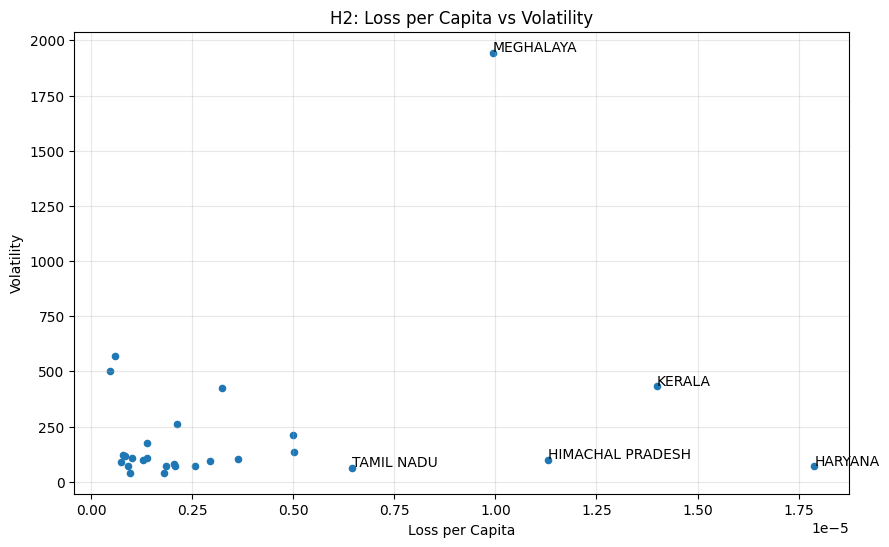

In [20]:
plt.figure(figsize=(10,6))
plt.scatter(df_master["Loss_per_Capita"], df_master["Volatility"], s=20)
plt.xlabel("Loss per Capita")
plt.ylabel("Volatility")
plt.title("H2: Loss per Capita vs Volatility")
plt.grid(alpha=0.3)

# annotate a few interesting points automatically
for i in df_master.nlargest(7, "Loss_per_Capita").index:
    plt.text(df_master.loc[i,"Loss_per_Capita"],
             df_master.loc[i,"Volatility"] + 5,
             df_master.loc[i,"State"],
             )

plt.show()


In [21]:
from scipy.stats import spearmanr

pears = df_master[["Loss_per_Capita", "Volatility"]].corr()
print("Pearson's : \n", pears)
print("\n")
spear, p = spearmanr(df_master["Loss_per_Capita"].fillna(0), df_master["Volatility"].fillna(0))
print("Spearman's : ", spear, p)




Pearson's : 
                  Loss_per_Capita  Volatility
Loss_per_Capita         1.000000    0.263304
Volatility              0.263304    1.000000


Spearman's :  0.2713487909541061 0.11484916036982895


- Loss per Capita - **weak relationship** with Volatility.  
- Pearson = 0.26 and Spearman = 0.27 - states with high Loss per Capita dont always show higher volatility.

### **Conclusion for H2**

The scatter plot shows no visible trend between Loss per Capita and volatility. States with high per-capita losses do not show higher volatility, and some low per-capita states show extreme volatility. The correlations are also weak (Pearson ≈ 0.26, Spearman ≈ 0.27, p > 0.05).

**Therefore, H2 is supported: Loss per Capita does not explain or predict volatility.**


--------------------------------------------------------------------------------------------------

### 4.4.3 H3

*   States with higher Branch Density -> lower Loss per Branch

In [23]:
df_master[["State", "Branches_per_Million", "Loss_per_Branch"]].sort_values("Loss_per_Branch", ascending=False).head(10)


,State,Branches_per_Million,Loss_per_Branch
10,HARYANA,850.438567,0.021031
31,TRIPURA,1398.590901,0.008354
18,MAHARASHTRA,445.070237,0.008146
29,TAMIL NADU,934.839019,0.006908
14,KARNATAKA,760.321460,0.006550
15,KERALA,2518.166905,0.005559
30,TELANGANA,173.924600,0.004561
34,WEST BENGAL,461.039990,0.004017
32,UTTAR PRADESH,790.303888,0.003707
20,MEGHALAYA,3503.325012,0.002834


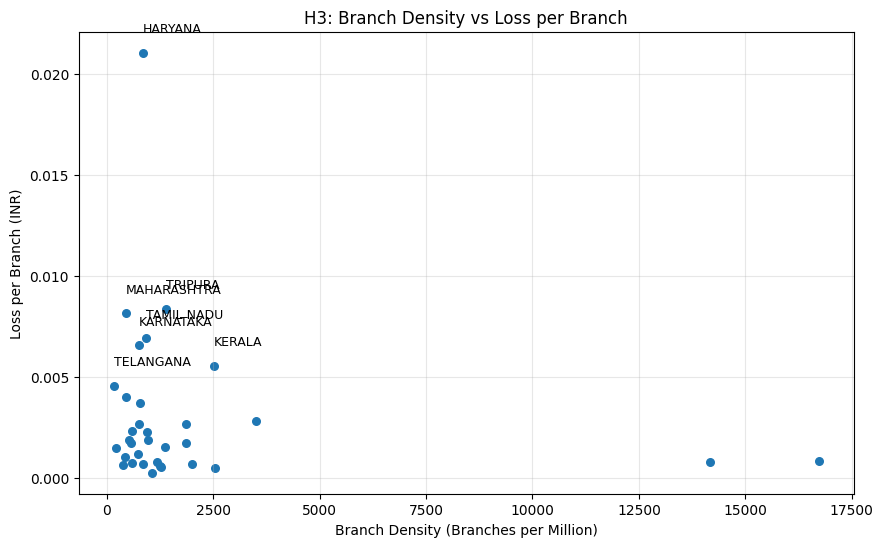

In [25]:
plt.figure(figsize=(10,6))
plt.scatter(df_master["Branches_per_Million"], df_master["Loss_per_Branch"], s=30)
plt.xlabel("Branch Density (Branches per Million)")
plt.ylabel("Loss per Branch (INR)")
plt.title("H3: Branch Density vs Loss per Branch")
plt.grid(alpha=0.3)

# Annotate top 7 states by Loss per Branch
top_states = df_master.nlargest(7, "Loss_per_Branch").index

for i in top_states:
    plt.text(
        df_master.loc[i, "Branches_per_Million"],
        df_master.loc[i, "Loss_per_Branch"] + 0.001,   # offset so labels don't overlap points
        df_master.loc[i, "State"],
        fontsize=9
    )

plt.show()


In [44]:
from scipy.stats import spearmanr

pears = df_master[["Branches_per_Million", "Loss_per_Branch"]].corr()
print("Pearson's : \n", pears)
print("\n")
spear, p = spearmanr(df_master["Branches_per_Million"].fillna(0), df_master["Loss_per_Branch"].fillna(0))
print("Spearman's : ", spear, p)


Pearson's : 
                       Branches_per_Million  Loss_per_Branch
Branches_per_Million              1.000000        -0.157694
Loss_per_Branch                  -0.157694         1.000000


Spearman's :  -0.02871349541322536 0.869939265108373


In [33]:
Q1 = df_master["Branches_per_Million"].quantile(0.25)
Q3 = df_master["Branches_per_Million"].quantile(0.75)
IQR = Q3 - Q1

df_clean = df_master[
    (df_master["Branches_per_Million"] > Q1 - 1.5*IQR) &
    (df_master["Branches_per_Million"] < Q3 + 1.5*IQR)
]


In [43]:
from scipy.stats import spearmanr

pears = df_clean[["Branches_per_Million", "Loss_per_Branch"]].corr()
print("Pearson's : \n", pears)
print("\n")
spear, p = spearmanr(df_clean["Branches_per_Million"].fillna(0), df_clean["Loss_per_Branch"].fillna(0))
print("Spearman's : ", spear, p)


Pearson's : 
                       Branches_per_Million  Loss_per_Branch
Branches_per_Million              1.000000        -0.076039
Loss_per_Branch                  -0.076039         1.000000


Spearman's :  -0.160845383759733 0.3958253472885638


### **Conclusion for H3**

H3 is not supported: Branch density has little to no effect on loss per branch. Fraud burden per branch does not decrease in states with more branches per million people.




-----------------------------------------------------------------------------------------------

### 4.4.4 H4

States with lower literacy rates -> higher volatility

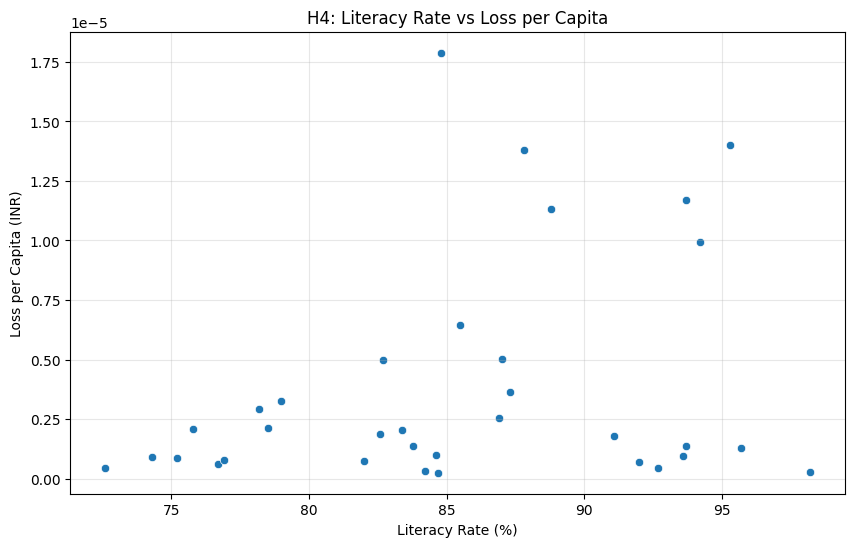

In [45]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_master,
    x="Literacy_Rate_Percent",
    y="Loss_per_Capita"
)

plt.xlabel("Literacy Rate (%)")
plt.ylabel("Loss per Capita (INR)")
plt.title("H4: Literacy Rate vs Loss per Capita")
plt.grid(alpha=0.3)
plt.show()


In [46]:
from scipy.stats import spearmanr

pears = df_clean[["Literacy_Rate_Percent", "Loss_per_Capita"]].corr()
print("Pearson's : \n", pears)
print("\n")
spear, p = spearmanr(df_clean["Literacy_Rate_Percent"].fillna(0), df_clean["Loss_per_Capita"].fillna(0))
print("Spearman's : ", spear, p)


Pearson's : 
                        Literacy_Rate_Percent  Loss_per_Capita
Literacy_Rate_Percent               1.000000         0.227661
Loss_per_Capita                     0.227661         1.000000


Spearman's :  0.13327400238215284 0.4826193478105477


### **Conclusion for H4**

H4 is not supported.
Literacy rates do not predict volatility in digital banking losses.

-------------------------------------------------------------------------------------------